In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 70)
import matplotlib.pyplot as plt
import ast
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import seaborn as sns

In [2]:
conversions = pd.read_parquet("conversions.parquet")
customers = pd.read_parquet("customers.parquet").reset_index()

In [6]:
conversions.head()

,REQUESTED_AT,VISITOR_ID
0,2022-01-14,db07fb0f4952db44383fb3a42e5169ef11eb23c9c5533d...
1,2022-01-12,a9b327fc32ae2c9749473b90145ba4b4a8dde11babba55...
2,2022-01-13,4d5e9ee969ae57389308cae43e2f5848871831fb9d539b...
3,2022-01-12,6e3f99c954427f9171f6d80b73ad3eab67f251adb05ad5...
4,2022-01-12,9cf66459dcdf50ce55196b41e1b6816aad6ca7abc0ade1...


In [12]:
conversions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1735 entries, 0 to 2055
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   REQUESTED_AT  1735 non-null   object
 1   VISITOR_ID    1735 non-null   object
dtypes: object(2)
memory usage: 40.7+ KB


In [11]:
# check for no duplicates in the ids
conversions['VISITOR_ID'].nunique()

1735

<AxesSubplot:>

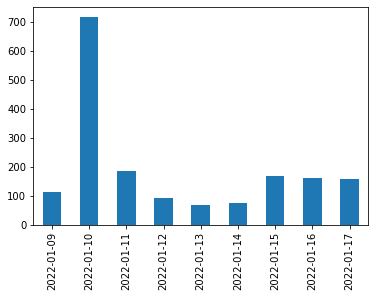

In [20]:
# it looks like most people converted on the 01/10
# there's a lull on 1/13 and 1/14 probably a weekday vs weekend thing.
conversions['REQUESTED_AT'].value_counts().sort_index().plot.bar()

In [241]:
# look at customers
customers.head()

,index,ID,REQUESTED_AT,SITE_ID,PAGE_VIEW_TYPE,PAGE_ID,SESSION_ID,VISITOR_ID,USER_AGENT,BROWSER_FAMILY,BROWSER,OS_FAMILY,OS,DEVICE_FAMILY,CONVERSION_SUMMARIES,FIRST_SEEN,PAGE_VIEW_SUMMARIES,SITE_NAME
0,0,ede83a5d270615e775e58b52708338c0f1eb2f94da89ab...,2022-01-10 23:39:41.873,2127,COLLECTIONS,collections.other,f90554292c6cb4bac43aca4e6b9554e90cca3256949d35...,c6a9c26d7910ca9daf97a9418798877e1d79f6daba5e22...,Mozilla/5.0 (iPhone; CPU iPhone OS 15_1 like M...,CHROME,CHROME_MOBILE,IOS,iOS15_IPHONE,MOBILE,[],"""2022-01-10T05:09:25.874Z""","[ { ""page_id"": ""home"", ""page_view_type"": ""HOME...",BCAI
1,1,e94b73775a847e648ce609a5c1b6cf570c3f1a7409c9ae...,2022-01-10 17:48:12.719,2127,COLLECTIONS,collections.paged,f1fc0a06609bce665fd5840caf163937919eb9c6a4d657...,b50db78c4459d75a734cdc8b15bff9ad665ac55a8bb5d8...,Mozilla/5.0 (iPhone; CPU iPhone OS 15_1 like M...,SAFARI,MOBILE_SAFARI,IOS,iOS15_IPHONE,MOBILE,[],"""2022-01-09T18:58:12.213Z""","[ { ""page_id"": ""home"", ""page_view_type"": ""HOME...",BCAI
2,2,7e139dff35f4fd9ed7163b7a03d13d8567e5f7cc83dc55...,2022-01-10 06:17:39.225,2127,PRODUCTS,collections.products,352920da35b3bd0d9b5be95a5042f70bec15a6bc8f125e...,7c86bb4b01418604526a813b9415eb6ede49dfa053a6f7...,Mozilla/5.0 (iPhone; CPU iPhone OS 14_8 like M...,SAFARI,MOBILE_SAFARI,IOS,iOS14_IPHONE,MOBILE,None,None,None,BCAI
3,3,ea0349ebd7617d70dd5b5b11cbf1bc9f39a12cd61c39d6...,2022-01-10 05:01:04.738,2127,HOME,home,413d412eebf3a57ea7cc1c5a7b04c12a1e038b0997f2ac...,ce5afc7d044a2910497e70c79d671445db398fc4cf6af4...,Mozilla/5.0 (iPhone; CPU iPhone OS 15_1 like M...,SAFARI,MOBILE_SAFARI,IOS,iOS15_IPHONE,MOBILE,None,None,None,BCAI
4,4,d235a545583ba6227411825ae5b834de58988f74359750...,2022-01-10 07:10:00.580,2127,HOME,home,639debd659f2931e6d6a4243c4a3cf125a1056e6fef74e...,daa51f8982f333f5e57571098479408d2ee20f2c929633...,Mozilla/5.0 (Linux; Android 9; KFONWI) AppleWe...,CHROME,CHROME9,ANDROID,ANDROID,MOBILE,None,None,None,BCAI


In [14]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24385 entries, 0 to 66
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID                    24385 non-null  object        
 1   REQUESTED_AT          24385 non-null  datetime64[ns]
 2   SITE_ID               24385 non-null  int16         
 3   PAGE_VIEW_TYPE        24385 non-null  object        
 4   PAGE_ID               24385 non-null  object        
 5   SESSION_ID            24385 non-null  object        
 6   VISITOR_ID            24385 non-null  object        
 7   USER_AGENT            24385 non-null  object        
 8   BROWSER_FAMILY        24385 non-null  object        
 9   BROWSER               24385 non-null  object        
 10  OS_FAMILY             24385 non-null  object        
 11  OS                    24385 non-null  object        
 12  DEVICE_FAMILY         24385 non-null  object        
 13  CONVERSION_SUMMARIE

## there are some nulls in the data, that will be to be sussed out.
- For now looking at the columns individually to see what makes sense

In [274]:
# no duplicates in a visitor ids
customers['VISITOR_ID'].describe()

count                                                 24385
unique                                                24385
top       c6a9c26d7910ca9daf97a9418798877e1d79f6daba5e22...
freq                                                      1
Name: VISITOR_ID, dtype: object

In [52]:
customers['DEVICE_FAMILY'].value_counts()

MOBILE      19394
COMPUTER     4802
TABLET        169
UNKNOWN        20
Name: DEVICE_FAMILY, dtype: int64

# Most people are checking mobile devices
- the OS column has too many enumerations, won't be useful to use as feature

In [51]:
customers['OS'].value_counts()

iOS15_IPHONE         10814
ANDROID1              3885
iOS14_IPHONE          3545
WINDOWS_10            2241
MAC_OS_X_10_15        1674
ANDROID_MOBILE         810
CHROME_OS              467
iOS13_IPHONE           125
WINDOWS_7              104
MAC_OS_X_10_14          91
ANDROID                 81
iOS12_IPHONE            79
iOS15_IPAD              76
MAC_OS_X_10_13          68
iOS14_IPAD              52
LINUX                   39
WINDOWS_81              37
MAC_OS_X_10_12          33
ANDROID6                31
UNKNOWN                 20
MAC_OS_X                17
ANDROID5_TABLET         16
iOS11_IPHONE            10
MAC_OS_X_10_11           9
MAC_OS_X_10_10           9
iOS12_IPAD               8
ANDROID5                 7
WINDOWS_8                5
UBUNTU                   5
ANDROID4_TABLET          5
iOS10_IPAD               4
iOS13_IPAD               4
iOS10_IPHONE             3
ANDROID6_TABLET          2
iOS11_IPAD               2
ANDROID4                 2
WINDOWS_10_MOBILE        1
M

## OS Family is better to use as feature, 
- but I thought it's informative on whether people purchase.

In [50]:
customers['OS_FAMILY'].value_counts()

IOS               14722
ANDROID            4839
WINDOWS            2388
MAC_OS_X           1904
CHROME_OS           467
LINUX                44
UNKNOWN              20
UNKNOWN_MOBILE        1
Name: OS_FAMILY, dtype: int64

In [ ]:
customers['BROWSER'].apply(lambda x: a if x in )

In [12]:
top_5 =customers['BROWSER'].value_counts()[:5].index.tolist()

In [17]:
customers['top_5_browser'].value_counts()

MOBILE_SAFARI      11057
CHROME_MOBILE       5542
CHROME9             3701
other               2079
APPLE_WEB_KIT       1113
MOBILE_SAFARI15      893
Name: top_5_browser, dtype: int64

In [16]:
customers['top_5_browser']= customers['BROWSER'].apply(lambda x: x if x in top_5 else 'other' )

In [49]:
# this has too many categories, not that useful
customers['BROWSER'].value_counts()

MOBILE_SAFARI         11057
CHROME_MOBILE          5542
CHROME9                3701
APPLE_WEB_KIT          1113
MOBILE_SAFARI15         893
GOOGLE_SEARCH_APP       505
SAFARI15                477
SAFARI14                390
FACEBOOK_APP            137
FIREFOX9                136
SAFARI13                 82
MOBILE_SAFARI14          69
SAFARI12                 21
FIREFOX_MOBILE           18
LIGHTHOUSE               16
BOT                      14
YANDEX                   14
CHROME76                 13
PINTEREST_APP            13
CHROME8                  12
CHROME89                 12
CHROME87                 11
FIREFOX7                 10
CHROME70                 10
CHROME81                 10
MOBILE_SAFARI10           7
CHROME86                  7
CHROME64                  6
MOBILE_SAFARI12           6
CHROME80                  6
UNKNOWN                   5
SAFARI10                  5
CHROME57                  5
CHROME88                  5
CHROME79                  5
MOBILE_SAFARI11     

In [48]:
customers['BROWSER_FAMILY'].value_counts()

SAFARI               13015
CHROME                9368
APPLE_WEB_KIT         1113
GOOGLE_SEARCH_APP      505
FIREFOX                172
FACEBOOK_APP           137
LIGHTHOUSE              16
YANDEX                  15
BOT                     14
PINTEREST_APP           13
IE                       6
UNKNOWN                  5
EDGE                     4
MOZILLA                  2
Name: BROWSER_FAMILY, dtype: int64

In [3]:
customers['USER_AGENT'].head()

0    Mozilla/5.0 (iPhone; CPU iPhone OS 15_1 like M...
1    Mozilla/5.0 (iPhone; CPU iPhone OS 15_1 like M...
2    Mozilla/5.0 (iPhone; CPU iPhone OS 14_8 like M...
3    Mozilla/5.0 (iPhone; CPU iPhone OS 15_1 like M...
4    Mozilla/5.0 (Linux; Android 9; KFONWI) AppleWe...
Name: USER_AGENT, dtype: object

## It looks like the other columns is probably processed from the user agent field 
- Won't be using this column for features

## Below the session isn't unique to visitor ID
- it looks like different visitorI ID's can have the same session ID
- Makes me wonder about identity management

In [45]:
customers['SESSION_ID'].nunique()

22441

In [34]:
session_count = customers.groupby('SESSION_ID').size().reset_index().rename(columns= {0:'session_count'})\
        .query('session_count > 1')
session_count.head()

,SESSION_ID,session_count
12,0031086dbf455d1819f94961d331d87f038931a72cb627...,2
17,00462ebcef275c1a30814290d451900f8281357094c968...,2
22,0058fd439f929608e3e07fd1c825725434609056a2e451...,2
23,005e4a7370152460f4468c7db753bffbae6b0f4f738103...,2
43,0097bf18c62af31caf1f3de6adf2c2aff7a86b8aaef86d...,2


In [35]:
customers.merge(session_count,on='SESSION_ID',how='left')

,index,ID,REQUESTED_AT,SITE_ID,PAGE_VIEW_TYPE,PAGE_ID,SESSION_ID,VISITOR_ID,USER_AGENT,BROWSER_FAMILY,BROWSER,OS_FAMILY,OS,DEVICE_FAMILY,CONVERSION_SUMMARIES,FIRST_SEEN,PAGE_VIEW_SUMMARIES,SITE_NAME,session_count
0,0,ede83a5d270615e775e58b52708338c0f1eb2f94da89ab...,2022-01-10 23:39:41.873,2127,COLLECTIONS,collections.other,f90554292c6cb4bac43aca4e6b9554e90cca3256949d35...,c6a9c26d7910ca9daf97a9418798877e1d79f6daba5e22...,Mozilla/5.0 (iPhone; CPU iPhone OS 15_1 like M...,CHROME,CHROME_MOBILE,IOS,iOS15_IPHONE,MOBILE,[],"""2022-01-10T05:09:25.874Z""","[ { ""page_id"": ""home"", ""page_view_type"": ""HOME...",BCAI,104.0
1,1,e94b73775a847e648ce609a5c1b6cf570c3f1a7409c9ae...,2022-01-10 17:48:12.719,2127,COLLECTIONS,collections.paged,f1fc0a06609bce665fd5840caf163937919eb9c6a4d657...,b50db78c4459d75a734cdc8b15bff9ad665ac55a8bb5d8...,Mozilla/5.0 (iPhone; CPU iPhone OS 15_1 like M...,SAFARI,MOBILE_SAFARI,IOS,iOS15_IPHONE,MOBILE,[],"""2022-01-09T18:58:12.213Z""","[ { ""page_id"": ""home"", ""page_view_type"": ""HOME...",BCAI,NaN
2,2,7e139dff35f4fd9ed7163b7a03d13d8567e5f7cc83dc55...,2022-01-10 06:17:39.225,2127,PRODUCTS,collections.products,352920da35b3bd0d9b5be95a5042f70bec15a6bc8f125e...,7c86bb4b01418604526a813b9415eb6ede49dfa053a6f7...,Mozilla/5.0 (iPhone; CPU iPhone OS 14_8 like M...,SAFARI,MOBILE_SAFARI,IOS,iOS14_IPHONE,MOBILE,None,None,None,BCAI,NaN
3,3,ea0349ebd7617d70dd5b5b11cbf1bc9f39a12cd61c39d6...,2022-01-10 05:01:04.738,2127,HOME,home,413d412eebf3a57ea7cc1c5a7b04c12a1e038b0997f2ac...,ce5afc7d044a2910497e70c79d671445db398fc4cf6af4...,Mozilla/5.0 (iPhone; CPU iPhone OS 15_1 like M...,SAFARI,MOBILE_SAFARI,IOS,iOS15_IPHONE,MOBILE,None,None,None,BCAI,2.0
4,4,d235a545583ba6227411825ae5b834de58988f74359750...,2022-01-10 07:10:00.580,2127,HOME,home,639debd659f2931e6d6a4243c4a3cf125a1056e6fef74e...,daa51f8982f333f5e57571098479408d2ee20f2c929633...,Mozilla/5.0 (Linux; Android 9; KFONWI) AppleWe...,CHROME,CHROME9,ANDROID,ANDROID,MOBILE,None,None,None,BCAI,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24380,62,65cdfe1e44559784bcd54460b19f80759f87d1fc79e5e0...,2022-01-10 07:20:12.299,2127,CHECKOUT,checkout,991035f2a6fc8091a752dc695a6e64d0d52b36841f3ef1...,b0d8decbba47a862a8ac1c2fb7ada9b0efbc6220f57cbd...,Mozilla/5.0 (Linux; Android 10; motorola one 5...,CHROME,CHROME_MOBILE,ANDROID,ANDROID1,MOBILE,[],"""2022-01-10T05:43:15.013Z""","[ { ""page_id"": ""home"", ""page_view_type"": ""HOME...",BCAI,NaN
24381,63,48ad626fc2cc9d008cddbc544d11e9c407390ef0bf79c2...,2022-01-10 11:31:41.636,2127,COLLECTIONS,collections.other,c06dff7f6b8b7961830ce768e744b64402207fc8847e2a...,956b5858c4e671d1891216a64f6a3da1888a80a641a96d...,Mozilla/5.0 (iPhone; CPU iPhone OS 15_1 like M...,SAFARI,MOBILE_SAFARI,IOS,iOS15_IPHONE,MOBILE,[],"""2022-01-08T21:58:37.273Z""","[ { ""page_id"": ""home"", ""page_view_type"": ""HOME...",BCAI,NaN
24382,64,2ed125b93e03ce31d2e421066e936f828a261345b31950...,2022-01-10 05:05:49.243,2127,COLLECTIONS,collections.newarrival,755a83c157a0c21a7a41e8bdc6e4cd937f6177f754efa8...,a8158120e20a052a4dd8922bfb2b2ca376a96ce2a62fd8...,Mozilla/5.0 (iPhone; CPU iPhone OS 14_8_1 like...,SAFARI,MOBILE_SAFARI,IOS,iOS14_IPHONE,MOBILE,[],"""2022-01-02T22:15:17.010Z""","[ { ""page_id"": ""home"", ""page_view_type"": ""HOME...",BCAI,NaN
24383,65,30b7b9d8f303345817f6902f719456ac4728155ff5d29d...,2022-01-10 13:36:10.451,2127,CHECKOUT,orders.other,a3dcdf1b80fc9cad17b1fccc408a0babf8ebf2eabacd19...,d58488ba16f04068467fc9584192c970a65cbaf13755b0...,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,CHROME,CHROME9,WINDOWS,WINDOWS_10,COMPUTER,[],"""2021-12-08T07:04:27.411Z""","[ { ""page_id"": ""collections.other"", ""page_view...",BCAI,NaN


In [43]:
# prefer to use the PAGE_VIEW_TYPE over this column
customers['PAGE_ID'].value_counts()

home                       4654
collections.other          4444
collections.paged          2370
collections.products       2047
pages                      1661
products.other             1630
collections.newarrival     1587
collections.bestsellers    1245
cart                        906
account                     608
orders.other                576
collections.oki             555
addtocart                   491
checkout                    463
confirmation                460
other                       193
collections.tools           118
collections.hair            113
search                       87
collections.stationary       86
collections.bath             77
collections.socks            14
Name: PAGE_ID, dtype: int64

In [40]:
customers['SITE_ID'].value_counts()

2127    24385
Name: SITE_ID, dtype: int64

<AxesSubplot:>

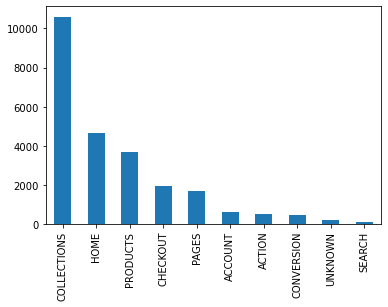

In [42]:
# people are searching on collections
customers['PAGE_VIEW_TYPE'].value_counts().plot.bar()

In [36]:
# the data is just for the one day
customers['REQUESTED_AT'].dt.date.unique()

array([datetime.date(2022, 1, 10)], dtype=object)

# Processing the first seen column
- extract the data information
- fill in the null with the default date 1/10/22

In [5]:
customers['first_date'] = pd.to_datetime(customers['FIRST_SEEN'].str.split('T').str.get(0).str.replace('"',"")).fillna('2022-01-10')
customers['first_month'] = customers['first_date'].dt.month
customers['first_year'] = customers['first_date'].dt.year
customers['first_day'] = customers['first_date'].dt.day

## Most of the customers first arrived in the last week before the 10th


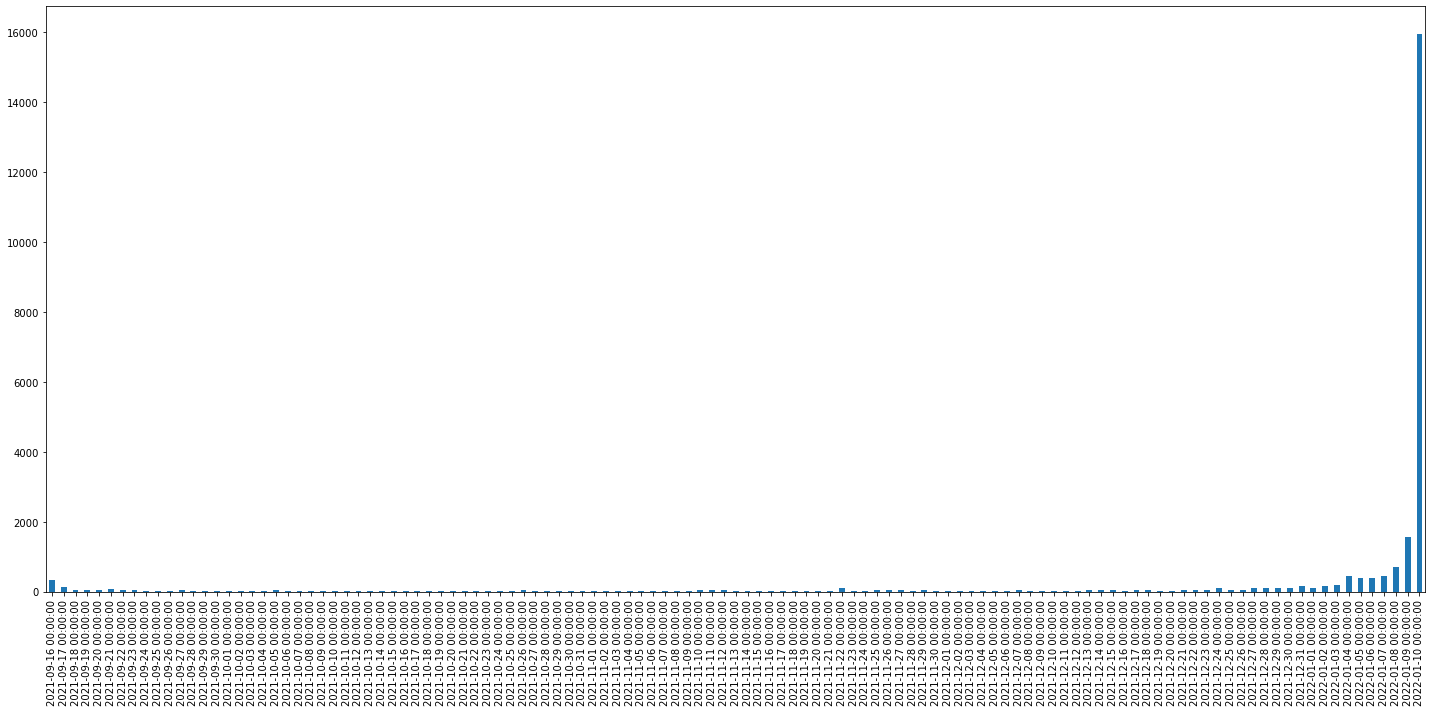

In [334]:
customers['first_date'].value_counts().sort_index().plot.bar(figsize=(20, 10))
plt.tight_layout()

## Getting the customer tenure on the site
- maybe older customers are more likely to convert.

In [6]:
customers['time_first_seen'] = (pd.to_datetime('2022-01-10') - customers['first_date']).astype('str')\
                .str.split('days').str.get(0).astype('float')

In [39]:
customers['time_first_seen'].describe()

count    24385.000000
mean        10.616486
std         27.168875
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max        116.000000
Name: time_first_seen, dtype: float64

## median tenure is 0
- most customers are new
- features will be have be based on the customer behavior on the site

<AxesSubplot:ylabel='Frequency'>

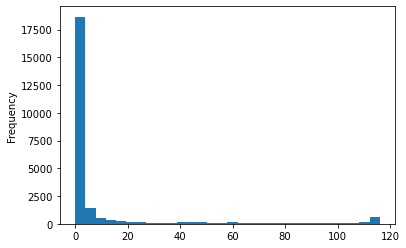

In [40]:
customers['time_first_seen'].plot.hist(bins=30)

In [94]:
customers['first_year'].value_counts()

2022.0    15155
2021.0     4027
Name: first_year, dtype: int64

<AxesSubplot:>

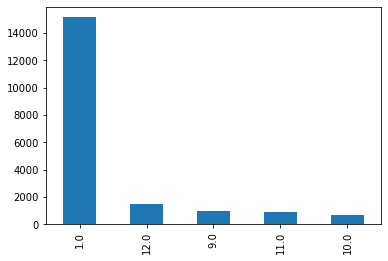

In [93]:
customers['first_month'].value_counts().plot.bar()

## Getting the target columns
- need the customers who transact in the next 7 days. 
- the data is for the 10th, and we need customers purchased after the 10th

In [7]:
conversions['REQUESTED_AT'] = pd.to_datetime(conversions['REQUESTED_AT'])

In [8]:
next_7 = conversions[conversions['REQUESTED_AT'] > '2022-01-10']
next_7['REQUESTED_AT'].value_counts()

2022-01-11    186
2022-01-15    169
2022-01-16    160
2022-01-17    156
2022-01-12     93
2022-01-14     75
2022-01-13     69
Name: REQUESTED_AT, dtype: int64

In [9]:
customers = customers.merge(next_7,on='VISITOR_ID',how='left')
customers['target'] = customers['REQUESTED_AT_y'].notna().astype('int')

In [51]:
customers['target'].value_counts()

0    23477
1      908
Name: target, dtype: int64

## Imbalanced target
- accuracy won't capture the model metrics
- we care more about mislabling customers who converted, so I will be focused on precision and auc
- More focus on the precision as those are percentage of the positive labels that are actually correct

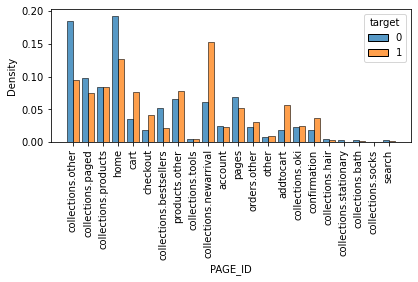

In [69]:
sns.histplot(data=customers, x = 'PAGE_ID', hue='target', multiple="dodge", 
                  stat = 'density', shrink = 0.8, common_norm=False)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## some page sites matter than others
- collections.newarrival is overrepresented in those who convert


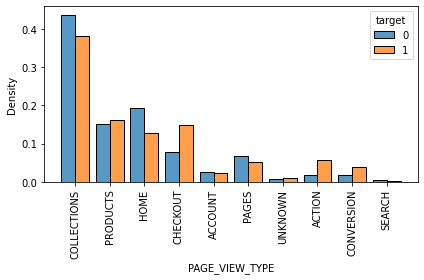

In [68]:
sns.histplot(data=customers, x = 'PAGE_VIEW_TYPE', hue='target', multiple="dodge", 
                  stat = 'density', shrink = 0.8, common_norm=False)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

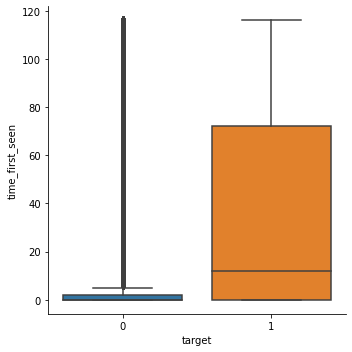

In [56]:
sns.catplot(x="target", y="time_first_seen",kind="box", data=customers)

## those who convert to tend have more complex past histories.

## Baseline Model
- go with a tree model for simplicity
- use the customer tenure and "DEVICE_FAMILY","PAGE_VIEW_TYPE",'OS_FAMILY' as first features

In [10]:
X = customers
y = customers['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42,stratify=y)

In [188]:
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

numeric_features = ["time_first_seen"]
categorical_features = ["DEVICE_FAMILY","PAGE_ID",'OS_FAMILY']

categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1)

# categorical_encoder =OneHotEncoder(handle_unknown="ignore")
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_features),
        ("num", numerical_pipe, numeric_features),
    ],
    remainder="drop",
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=234,class_weight='balanced')),
    ]
)

results = cross_validate(rf, X_train, y_train, cv=3,scoring=['roc_auc','recall','precision'])
rf.fit(X_train, y_train.values.ravel())


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['DEVICE_FAMILY', 'PAGE_ID',
                                                   'OS_FAMILY']),
                                                 ('num', SimpleImputer(),
                                                  ['time_first_seen'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=234))])

In [189]:
results

{'fit_time': array([0.35581303, 0.37858081, 0.39329267]),
 'score_time': array([0.10770321, 0.1219883 , 0.11775208]),
 'test_roc_auc': array([0.45888701, 0.51745619, 0.49169469]),
 'test_recall': array([0.1745283 , 0.14150943, 0.19339623]),
 'test_precision': array([0.0729783 , 0.07792208, 0.09234234])}

In [190]:
results['test_precision'].mean()

0.08108090800398493

In [191]:
## results on the validation set
y_true = y_test
y_preds = rf.predict(X_test)

accuracy = accuracy_score(y_true,y_preds)
precision = precision_score(y_true,y_preds)
recall = recall_score(y_true,y_preds)
auc = roc_auc_score(y_true,rf.predict_proba(X_test)[:, 1])

print('accuracy',accuracy,'precision',precision,'recall',recall,'auc',auc)

print("confusion matrix")
confusion_matrix(y_true,y_preds)

accuracy 0.8933843630399125 precision 0.09032258064516129 recall 0.20588235294117646 auc 0.4966648712295822
confusion matrix


array([[6480,  564],
       [ 216,   56]])

## The precision is really low on the order of 10%
- Let's see about using a more complicated model
- we see below that the most relevant feature is the customer tenure

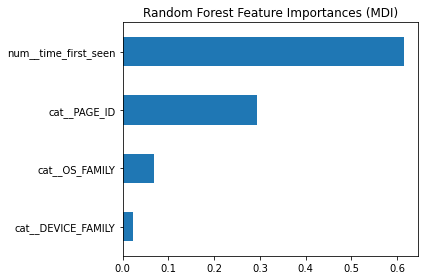

In [192]:
feature_names = rf[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    rf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()
plt.show()

## Add more features
- use the summaries columns to see if we can add more features

In [37]:
# get rows that aren't null
summaries = customers[(customers['CONVERSION_SUMMARIES'] != '[]') & customers['CONVERSION_SUMMARIES'].notna()]\
            [['CONVERSION_SUMMARIES','VISITOR_ID']]
summaries.head()

,CONVERSION_SUMMARIES,VISITOR_ID
5,"[ { ""conversion_value"": 33.95, ""product_catego...",67f65c24a22a496c12c8af56f175e3a6c268ff8527af39...
12,"[ { ""conversion_value"": 19, ""product_category_...",e3d8633d91c7736f008cc9546ca939bd3777362493068d...
39,"[ { ""conversion_value"": 40.61, ""product_catego...",6e4dc224b794e066bfdef1e18bc631445ee44f7f58ba24...
41,"[ { ""conversion_value"": 37.91, ""product_catego...",80f2529b717d94acc94a4f4a03a16b437aa83bc0b82c30...
49,"[ { ""conversion_value"": 8.93, ""product_categor...",36dfa7ff136ab7819824b63b0a0eea723d84d01df7f14f...


In [38]:
# get the latest conversion date.  
summaries['last_conversion_date']= pd.to_datetime(summaries['CONVERSION_SUMMARIES'].apply(ast.literal_eval)\
.apply(lambda x:x[-1]['requested_at']).str.split('T').str.get(0).str.replace('"',""))

In [39]:
# get the last conversion value
summaries['num_conversions'] = summaries['CONVERSION_SUMMARIES'].apply(ast.literal_eval)\
.apply(lambda x:len(x))

In [40]:
# get the mean of the conversion value
summaries['mean_conversion_value'] = summaries['CONVERSION_SUMMARIES'].apply(ast.literal_eval)\
.apply(lambda x:np.mean([a['conversion_value'] for a in x]))

In [431]:
cus_summaries = customers.join(summaries[['last_conversion_date','last_conversion_value','mean_conversion_value']],)

## Look at the page summaries as well

In [42]:
page_summaries = customers[(customers['PAGE_VIEW_SUMMARIES'] != '[]') & customers['PAGE_VIEW_SUMMARIES'].notna()]\
                [['PAGE_VIEW_SUMMARIES','VISITOR_ID']]
page_summaries

,PAGE_VIEW_SUMMARIES,VISITOR_ID
0,"[ { ""page_id"": ""home"", ""page_view_type"": ""HOME...",c6a9c26d7910ca9daf97a9418798877e1d79f6daba5e22...
1,"[ { ""page_id"": ""home"", ""page_view_type"": ""HOME...",b50db78c4459d75a734cdc8b15bff9ad665ac55a8bb5d8...
5,"[ { ""page_id"": ""collections.other"", ""page_view...",67f65c24a22a496c12c8af56f175e3a6c268ff8527af39...
6,"[ { ""page_id"": ""collections.other"", ""page_view...",1168fa28d9c9720268efa50a1f88cf50c25fd9f1ebbcf7...
8,"[ { ""page_id"": ""collections.other"", ""page_view...",a3f731c129f76663acf4c5ed992c541fc75a3ef79ccf3d...
...,...,...
24379,"[ { ""page_id"": ""collections.other"", ""page_view...",f546ddf9afc3bd0af55b309f4707e70910ab269dc6f88b...
24380,"[ { ""page_id"": ""home"", ""page_view_type"": ""HOME...",b0d8decbba47a862a8ac1c2fb7ada9b0efbc6220f57cbd...
24381,"[ { ""page_id"": ""home"", ""page_view_type"": ""HOME...",956b5858c4e671d1891216a64f6a3da1888a80a641a96d...
24382,"[ { ""page_id"": ""home"", ""page_view_type"": ""HOME...",a8158120e20a052a4dd8922bfb2b2ca376a96ce2a62fd8...


In [43]:
# get all the page view lists
page_summaries['page_view_type_list'] = page_summaries['PAGE_VIEW_SUMMARIES'].apply(ast.literal_eval)\
.apply(lambda x:[a['page_view_type'] for a in x])

In [44]:
page_summaries['page_id_list'] = page_summaries['PAGE_VIEW_SUMMARIES'].apply(ast.literal_eval)\
.apply(lambda x:[a['page_id'] for a in x])

In [45]:
page_summaries['pages_times'] = page_summaries['PAGE_VIEW_SUMMARIES'].apply(ast.literal_eval)\
.apply(lambda x:[a['requested_at'] for a in x])

In [46]:
page_summaries['count_pages'] = page_summaries['PAGE_VIEW_SUMMARIES'].apply(ast.literal_eval)\
.apply(lambda x:len(x))

In [438]:
page_summaries.columns

Index(['index', 'ID', 'REQUESTED_AT', 'SITE_ID', 'PAGE_VIEW_TYPE', 'PAGE_ID',
       'SESSION_ID', 'VISITOR_ID', 'USER_AGENT', 'BROWSER_FAMILY', 'BROWSER',
       'OS_FAMILY', 'OS', 'DEVICE_FAMILY', 'CONVERSION_SUMMARIES',
       'FIRST_SEEN', 'PAGE_VIEW_SUMMARIES', 'SITE_NAME', 'first_date',
       'first_month', 'first_year', 'first_day', 'time_first_seen',
       'page_view_type_list', 'page_id_list', 'pages_times', 'count_pages'],
      dtype='object')

In [47]:
page_summaries['count_conversion'] = page_summaries['page_view_type_list'].apply(lambda x : sum([1 for a in x if a =='CONVERSION']))

In [56]:
page_summaries['count_cart'] = page_summaries['page_id_list'].apply(lambda x : sum([1 for a in x if a =='cart']))
page_summaries['count_new'] = page_summaries['page_id_list'].apply(lambda x : sum([1 for a in x if a =='collections.newarrival']))
page_summaries['count_confirmation'] = page_summaries['page_id_list'].apply(lambda x : sum([1 for a in x if a =='confirmation']))


In [48]:
page_summaries['count_addcart'] = page_summaries['page_id_list'].apply(lambda x : sum([1 for a in x if a =='addtocart']))

In [49]:
page_summaries['count_checkout'] = page_summaries['page_view_type_list'].apply(lambda x : sum([1 for a in x if a =='CHECKOUT']))

In [50]:
summaries['time_conversion'] = (pd.to_datetime('2022-01-10') - summaries['last_conversion_date']).astype('str').str.split('days').str.get(0)

In [63]:
cus_summaries = customers.merge(summaries[['VISITOR_ID', 'last_conversion_date',
       'num_conversions', 'mean_conversion_value', 'time_conversion']],on='VISITOR_ID',how='left')\
.merge(page_summaries[['VISITOR_ID', 'page_view_type_list',
       'page_id_list', 'pages_times', 'count_pages', 'count_conversion',
       'count_addcart', 'count_checkout', 'count_cart', 'count_new',
       'count_confirmation']],on='VISITOR_ID',how='left')\



In [64]:
cus_summaries.columns

Index(['index', 'ID', 'REQUESTED_AT_x', 'SITE_ID', 'PAGE_VIEW_TYPE', 'PAGE_ID',
       'SESSION_ID', 'VISITOR_ID', 'USER_AGENT', 'BROWSER_FAMILY', 'BROWSER',
       'OS_FAMILY', 'OS', 'DEVICE_FAMILY', 'CONVERSION_SUMMARIES',
       'FIRST_SEEN', 'PAGE_VIEW_SUMMARIES', 'SITE_NAME', 'first_date',
       'first_month', 'first_year', 'first_day', 'time_first_seen',
       'REQUESTED_AT_y', 'target', 'last_conversion_date', 'num_conversions',
       'mean_conversion_value', 'time_conversion', 'page_view_type_list',
       'page_id_list', 'pages_times', 'count_pages', 'count_conversion',
       'count_addcart', 'count_checkout', 'count_cart', 'count_new',
       'count_confirmation'],
      dtype='object')

## we have to resolve the nulls in the new columns

In [65]:
cus_summaries['time_conversion'] = cus_summaries['time_conversion'].astype('float')
cus_summaries['time_conversion'].describe()
# cus_summaries['time_conversion'].fillna()

count    2221.000000
mean       25.094102
std        25.609870
min         0.000000
25%         3.000000
50%        14.000000
75%        44.000000
max       116.000000
Name: time_conversion, dtype: float64

In [66]:
# default max time for time of latest conversion
cus_summaries['time_conversion'].fillna(200,inplace=True)

In [67]:
cus_summaries['mean_conversion_value'].isnull().value_counts()

True     22164
False     2221
Name: mean_conversion_value, dtype: int64

In [68]:
# null conversions are 0
cus_summaries['mean_conversion_value'].fillna(0,inplace=True)

In [69]:
cus_summaries['count_pages'].isnull().value_counts()

False    19182
True      5203
Name: count_pages, dtype: int64

In [70]:
cus_summaries['count_conversion'].isnull().value_counts()

False    19182
True      5203
Name: count_conversion, dtype: int64

In [74]:
cus_summaries['count_pages'].fillna(0,inplace=True)
cus_summaries['count_conversion'].fillna(0,inplace=True)
cus_summaries['count_checkout'].fillna(0,inplace=True)
cus_summaries['count_addcart'].fillna(0,inplace=True)
cus_summaries['count_new'].fillna(0,inplace=True)
cus_summaries['count_cart'].fillna(0,inplace=True)
cus_summaries['count_confirmation'].fillna(0,inplace=True)
cus_summaries['num_conversions'].fillna(0,inplace=True)

In [75]:
cus_summaries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24385 entries, 0 to 24384
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  24385 non-null  int64         
 1   ID                     24385 non-null  object        
 2   REQUESTED_AT_x         24385 non-null  datetime64[ns]
 3   SITE_ID                24385 non-null  int16         
 4   PAGE_VIEW_TYPE         24385 non-null  object        
 5   PAGE_ID                24385 non-null  object        
 6   SESSION_ID             24385 non-null  object        
 7   VISITOR_ID             24385 non-null  object        
 8   USER_AGENT             24385 non-null  object        
 9   BROWSER_FAMILY         24385 non-null  object        
 10  BROWSER                24385 non-null  object        
 11  OS_FAMILY              24385 non-null  object        
 12  OS                     24385 non-null  object        
 13  D

## use the same train test for the same baseline model

In [76]:
X_train_new=cus_summaries.loc[X_train.index]
X_test_new=cus_summaries.loc[X_test.index]
y_train_new = cus_summaries['target'].loc[X_train.index]
y_test_new = cus_summaries['target'].loc[X_test.index]



In [78]:
cus_summaries.columns

Index(['index', 'ID', 'REQUESTED_AT_x', 'SITE_ID', 'PAGE_VIEW_TYPE', 'PAGE_ID',
       'SESSION_ID', 'VISITOR_ID', 'USER_AGENT', 'BROWSER_FAMILY', 'BROWSER',
       'OS_FAMILY', 'OS', 'DEVICE_FAMILY', 'CONVERSION_SUMMARIES',
       'FIRST_SEEN', 'PAGE_VIEW_SUMMARIES', 'SITE_NAME', 'first_date',
       'first_month', 'first_year', 'first_day', 'time_first_seen',
       'REQUESTED_AT_y', 'target', 'last_conversion_date', 'num_conversions',
       'mean_conversion_value', 'time_conversion', 'page_view_type_list',
       'page_id_list', 'pages_times', 'count_pages', 'count_conversion',
       'count_addcart', 'count_checkout', 'count_cart', 'count_new',
       'count_confirmation'],
      dtype='object')

In [93]:
customers['target'].value_counts()

0    23477
1      908
Name: target, dtype: int64

In [94]:
23477/908

25.855726872246695

In [77]:
# try xgboost
import xgboost as xgb

In [133]:
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

numeric_features = ["time_first_seen",
       'mean_conversion_value', 'time_conversion', 'count_pages',
       'count_addcart', 'count_checkout', 'count_cart', 'count_new',
       'count_confirmation']
categorical_features = ["DEVICE_FAMILY","PAGE_ID",'OS_FAMILY']

categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_features),
        ("num", numerical_pipe, numeric_features),
    ],
)

clf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=234,class_weight='balanced_subsample')),
    ]
)

results = cross_validate(clf, X_train_new, y_train_new, cv=3,scoring=['roc_auc','recall','precision'])
clf.fit(X_train_new, y_train_new.values.ravel())


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['DEVICE_FAMILY', 'PAGE_ID',
                                                   'OS_FAMILY']),
                                                 ('num', SimpleImputer(),
                                                  ['time_first_seen',
                                                   'mean_conversion_value',
                                                   'time_conversion',
                                                   'count_pages',
                                                   'count_addcart',
                                                   'count_checkout',
                                                   'count_cart', 'count_new',
                                                   'count_confirmation'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        random_state=234))])

In [134]:
results

{'fit_time': array([0.7096231 , 0.75113297, 0.73905611]),
 'score_time': array([0.12392998, 0.12989902, 0.13401818]),
 'test_roc_auc': array([0.73071101, 0.70291113, 0.7406879 ]),
 'test_recall': array([0.02358491, 0.04716981, 0.05188679]),
 'test_precision': array([0.12820513, 0.28571429, 0.19642857])}

In [135]:
y_true = y_test_new
y_preds = clf.predict(X_test_new)

accuracy = accuracy_score(y_true,y_preds)
precision = precision_score(y_true,y_preds)
recall = recall_score(y_true,y_preds)

auc = roc_auc_score(y_true,clf.predict_proba(X_test_new)[:, 1])

print('accuracy',accuracy,'precision',precision,'recall',recall,'auc',auc)

print("confusion matrix")
confusion_matrix(y_true,y_preds)

accuracy 0.9570803717878622 precision 0.1111111111111111 recall 0.022058823529411766 auc 0.7219950959514981
confusion matrix


array([[6996,   48],
       [ 266,    6]])

## The new model isn't much better with the extra features
- The auc is better but the precision is barely improved. Instead, the recall has worsened.
- we would have to devote some time to feature selection, it looks like the extra features
are making the model noisy

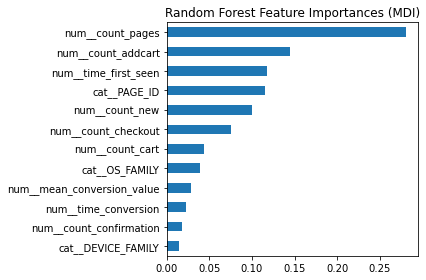

In [115]:
feature_names = clf[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    clf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

## the count of number previous pages looks like the most important feature

## Try xgboost


In [154]:
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

numeric_features = ["time_first_seen",
       'mean_conversion_value', 'time_conversion', 'count_pages',
       'count_addcart', 'count_checkout', 'count_cart', 'count_new',
       'count_confirmation']

categorical_features = ["DEVICE_FAMILY","PAGE_ID",'OS_FAMILY']

# categorical_encoder = OrdinalEncoder(
#     handle_unknown="use_encoded_value", unknown_value=-1)

categorical_encoder = OneHotEncoder(handle_unknown="ignore") 
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_features),
        ("num", numerical_pipe, numeric_features),
    ],
)


clf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", xgb.XGBClassifier()),
    ]
)

results = cross_validate(clf, X_train_new, y_train_new, cv=3,scoring=['roc_auc','recall','precision'])
clf.fit(X_train_new, y_train_new.values.ravel())
print(results)
print("CV_precision:", results['test_precision'].mean())

y_true = y_test_new
y_preds = clf.predict(X_test_new)

accuracy = accuracy_score(y_true,y_preds)
precision = precision_score(y_true,y_preds)
recall = recall_score(y_true,y_preds)
auc = roc_auc_score(y_true,clf.predict_proba(X_test_new)[:, 1])

print('accuracy',accuracy,'precision',precision,'\nrecall',recall,'auc',auc)

print("confusion matrix")
confusion_matrix(y_true,y_preds)


{'fit_time': array([0.35017014, 0.34118724, 0.37158298]), 'score_time': array([0.0330019 , 0.03429389, 0.03612781]), 'test_roc_auc': array([0.77623702, 0.75175961, 0.77587062]), 'test_recall': array([0.05660377, 0.07075472, 0.07075472]), 'test_precision': array([0.29268293, 0.34883721, 0.27777778])}
CV_precision: 0.30643263796979053
accuracy 0.9602241662110443 precision 0.3389830508474576 
recall 0.07352941176470588 auc 0.7952596285532952
confusion matrix


array([[7005,   39],
       [ 252,   20]])

# Final take away
- xgboost vanilla model is better, with improved precision and auc have improved
- We would have to tune class weights and feature selection to see better metrics
- however the baseline model has got the best recall so far.
- there are features can be gleaned from the summaries, but so far generating more informative takes priority.  

In [193]:
3 +2+4

9

In [215]:
def lop(x,y):
    return y*x/(3+4+7)

In [211]:
def jkk(x,y):
    return y*np.exp(-x)/(np.exp(-3)+np.exp(-4) +np.exp(-7))

In [217]:
lop(3,3) +lop(4,13)+lop(7,23)

15.857142857142858

In [218]:
jkk(3,1) + jkk(4,1) +jkk(7,1)

1.0000000000000002

In [199]:
3+2+4

9

In [209]:
jkk(7)

0.013212886953789417

In [210]:
jkk(3)

0.7213991842739688